###
수요 계산, 공급 계산하는 과정에서 접근거리에 따른 가중치 부여하자.
convex_hull -> 말고 osmid를 활용하여 접근해보자.


In [2]:
!pip install osmnx

In [4]:
!pip install tqdm

In [5]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import time
import numpy as np
from tqdm import tqdm, trange
from shapely.geometry import Point, MultiPoint
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

In [6]:
import os
print(os.getcwd())  # 현재 작업 디렉터리 출력


/Users/jin/Downloads/2SFCA


In [9]:
hospitals = gpd.read_file('./lab_13_1_data/hospitals.shp')
hospitals = hospitals.to_crs("epsg:4326")
dongs = gpd.read_file('./lab_13_1_data/dongs.shp')
dongs = dongs.to_crs("epsg:4326")

dongs_list = ['Dongdaemun, Seoul, South Korea',
          'Seongbuk, Seoul, South Korea',
          'Nowon, Seoul, South Korea',
          'Jungnang, Seoul, South Korea',
          'Gangbuk, Seoul, South Korea',
          'Dobong, Seoul, South Korea']
G = ox.graph_from_place(dongs_list, network_type='drive')
G.remove_nodes_from(list(nx.isolates(G)))

def nearest_osm(network, gdf):
    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, X=row.geometry.x, Y=row.geometry.y)
        elif row.geometry.geom_type =='Polygon' or row.geometry.geom_type =='MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, X=row.geometry.centroid.x, Y=row.geometry.centroid.y)
        else:
            print(row.geometry.geom_type)
            continue

        gdf.loc[idx, 'nearest_osm'] = nearest_osm
    
    return gdf

In [10]:
dist1 = 1000
dist2 = 3000
dist3 = 5000

In [11]:
supply= nearest_osm(G, hospitals)

100%|███████████████████████████████████████| 3299/3299 [00:41<00:00, 78.78it/s]


In [12]:
demand = nearest_osm(G, dongs)

100%|███████████████████████████████████████████| 68/68 [00:00<00:00, 73.73it/s]


In [13]:
supply_ = supply.copy(deep=True)
supply_['ratio'] = 0

In [14]:
nodes, edges = ox.graph_to_gdfs(G, nodes = True, edges = True, node_geometry = True)

In [15]:
demand.head(1)

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,Pop,geometry,nearest_osm
0,11230101,Sinseol-dong,신설동,3688,"POLYGON ((127.02441 37.57919, 127.02443 37.579...",4.173043e+09


In [16]:
nodes.head(1)

,y,x,street_count,junction,highway,ref,railway,geometry
osmid,,,,,,,,
282723724,37.588055,127.023541,3,NaN,NaN,NaN,NaN,POINT (127.02354 37.58805)


In [25]:
# decay_dic = {1000:1, 3000:0.68, 5000:0.22} # keys: mm, values: weight
# for i in tqdm(range(supply_.shape[0])):
    
#     temp_node1 = nx.single_source_dijkstra_path_length(G, supply_.loc[i,'nearest_osm'], dist1, weight='length')
#     temp_node2 = nx.single_source_dijkstra_path_length(G, supply_.loc[i,'nearest_osm'], dist2, weight='length')
#     temp_node3 = nx.single_source_dijkstra_path_length(G, supply_.loc[i,'nearest_osm'], dist3, weight='length')
    
#     access_node_index1 = set(temp_node1.keys())
#     access_node_index2 = set(temp_node2.keys()) - access_node_index1
#     access_node_index3 = set(temp_node3.keys()) - set(temp_node2.keys())

    
#     demand_sum_value1 = demand.loc[demand['nearest_osm'].isin(access_node_index1), 'Pop'].sum()
#     demand_sum_value2 = demand.loc[demand['nearest_osm'].isin(access_node_index2), 'Pop'].sum() * 0.68
#     demand_sum_value3 = demand.loc[demand['nearest_osm'].isin(access_node_index3), 'Pop'].sum() * 0.22
#     supply_value = supply_.loc[i,'총의사']
#     step1_ratio = supply_value / (demand_sum_value1 + demand_sum_value2 + demand_sum_value3)* 100000 # 100000을 안곱하니 비율이 매우 작게 나온다. 아래서 정규화를 하니 안해도 되나 싶지만, 일단 하자.
#     supply_.loc[i, 'ratio'] = step1_ratio


######
decay_dic = {1000:1, 3000:0.68, 5000:0.22}  # keys: m, values: weight

for i in tqdm(range(supply_.shape[0])):
    total_demand = 0
    prev_nodes = set()  # 이전 거리 구간 노드 누적
    
    # 거리 오름차순으로 정렬 (1000 → 3000 → 5000)
    for distance, weight in sorted(decay_dic.items(), key=lambda x: x[0]):
        # 현재 거리까지의 모든 노드 계산
        temp_nodes = nx.single_source_dijkstra_path_length(G, supply_.loc[i, 'nearest_osm'], cutoff=distance, weight='length'
        ).keys()
        
        # 현재 구간 노드 = 전체 노드 - 이전 구간 노드
        current_nodes = set(temp_nodes) - prev_nodes
        
        # 수요 계산 및 가중치 적용
        demand_sum = demand.loc[demand['nearest_osm'].isin(current_nodes), 'Pop'].sum() * weight
        
        total_demand += demand_sum
        
        # 다음 구간을 위해 노드 업데이트
        prev_nodes.update(temp_nodes)
    
    # 최종 ratio 계산
    supply_value = supply_.loc[i, '총의사']
    step1_ratio = (supply_value / total_demand) * 100000
    supply_.loc[i, 'ratio'] = step1_ratio


    

100%|███████████████████████████████████████| 3299/3299 [01:02<00:00, 53.01it/s]


In [26]:
supply_

,요양기,읍면동,주소,총의사,의과일,의과인,의과레,의과전,치과일,치과인,...,한방인,한방레,한방전,조산사,좌표_X_,좌표_Y_,시군구,geometry,nearest_osm,ratio
0,의료법인마리아의료재단마리아병원,신설동,"서울특별시 동대문구 천호대로 20, (신설동)",11,0,0,0,11,0,0,...,0,0,0,0,127.025329,37.574227,동대문구,POINT (127.02533 37.57423),3.829262e+09,6.661534
1,더드림요양병원,신설동,"서울특별시 동대문구 한빛로 12, 지하1층 ~ 4층 (신설동)",6,1,0,0,4,0,0,...,0,0,0,0,127.024889,37.576758,동대문구,POINT (127.02489 37.57676),3.829133e+09,2.702670
2,고려M영상의학과의원,신설동,"서울특별시 동대문구 천호대로 2, 이지빌딩 5층 (신설동)",1,0,0,0,1,0,0,...,0,0,0,0,127.023607,37.575043,동대문구,POINT (127.02361 37.57504),1.939144e+09,0.644038
3,동대문조은신경외과의원,신설동,"서울특별시 동대문구 왕산로 10, 4층 (신설동)",1,0,0,0,1,0,0,...,0,0,0,0,127.024881,37.575895,동대문구,POINT (127.02488 37.5759),3.829133e+09,0.497670
4,동서울정형외과의원,신설동,"서울특별시 동대문구 왕산로 21, 민족통일대통령빌딩 3층 (신설동)",2,0,0,0,2,0,0,...,0,0,0,0,127.025808,37.576807,동대문구,POINT (127.02581 37.57681),3.829133e+09,0.900890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,화진한의원,중계동,"서울특별시 노원구 한글비석로 384, 301호 (중계동, 대호아파트상가)",2,0,0,0,0,0,0,...,0,0,0,0,127.073439,37.659927,노원구,POINT (127.07344 37.65993),4.634174e+09,0.649603
3295,화한의원,중계동,"서울특별시 노원구 한글비석로 362, 2층 (중계동, 중석빌딩)",2,0,0,0,0,0,0,...,0,0,0,0,127.074864,37.658212,노원구,POINT (127.07486 37.65821),3.839664e+09,0.649603
3296,효성한의원,상계동,"서울특별시 노원구 상계로27길 15, (상계동, 석경빌딩)",1,0,0,0,0,0,0,...,0,0,0,0,127.070252,37.659235,노원구,POINT (127.07025 37.65924),3.839574e+09,0.277053
3297,후한의원,상계동,"서울특별시 노원구 상계로 55, 위성프라자 601호 (상계동)",2,0,0,0,0,0,0,...,0,0,0,0,127.061196,37.656059,노원구,POINT (127.0612 37.65606),3.669430e+09,0.538507


In [27]:
demand_ = demand.copy(deep=True)
demand_['sum'] =0

In [28]:
# for z in tqdm(range(demand_.shape[0])):
#     temp_node1 = nx.single_source_dijkstra_path_length(G, demand_.loc[z, 'nearest_osm'], dist1, weight='length')
#     temp_node2 = nx.single_source_dijkstra_path_length(G, demand_.loc[z, 'nearest_osm'], dist2, weight='length')
#     temp_node3 = nx.single_source_dijkstra_path_length(G, demand_.loc[z, 'nearest_osm'], dist3, weight='length')

#     access_node_index1 = set(temp_node1.keys())
#     access_node_index2 = set(temp_node2.keys()) - access_node_index1
#     access_node_index3 = set(temp_node3.keys()) - set(temp_node2.keys())

#     sum_ratio1 = supply_.loc[supply_['nearest_osm'].isin(access_node_index1), 'ratio'].replace([np.inf, -np.inf], np.nan).dropna(axis=0).sum()
#     sum_ratio2 = supply_.loc[supply_['nearest_osm'].isin(access_node_index2), 'ratio'].replace([np.inf, -np.inf], np.nan).dropna(axis=0).sum() * 0.68
#     sum_ratio3 = supply_.loc[supply_['nearest_osm'].isin(access_node_index3), 'ratio'].replace([np.inf, -np.inf], np.nan).dropna(axis=0).sum() * 0.22
#     step2_sum_ratio = sum_ratio1 + sum_ratio2 + sum_ratio3
#     demand_.loc[z,'sum'] = step2_sum_ratio


decay_dic = {1000:1, 3000:0.68, 5000:0.22}  # keys: m, values: weight

for z in tqdm(range(demand_.shape[0])):
    total_sum = 0
    prev_nodes = set()  # 이전 거리 구간 노드 누적
    
    # 거리 오름차순으로 정렬 (1000 → 3000 → 5000)
    for distance, weight in sorted(decay_dic.items(), key=lambda x: x[0]):
        # 현재 거리까지의 모든 노드 계산
        temp_nodes = nx.single_source_dijkstra_path_length(G, demand_.loc[z, 'nearest_osm'], cutoff=distance, weight='length'
        ).keys()
        
        # 현재 구간 노드 = 전체 노드 - 이전 구간 노드
        current_nodes = set(temp_nodes) - prev_nodes
        
        # 공급 시설 ratio 합산 및 가중치 적용
        sum_ratio = supply_.loc[supply_['nearest_osm'].isin(current_nodes), 'ratio'].replace([np.inf, -np.inf], np.nan).dropna().sum() * weight
        
        total_sum += sum_ratio
        
        # 다음 구간을 위해 노드 업데이트
        prev_nodes.update(temp_nodes)
    
    # 최종 합계 계산
    demand_.loc[z, 'sum'] = total_sum




100%|███████████████████████████████████████████| 68/68 [00:01<00:00, 53.26it/s]


In [29]:
demand_

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,Pop,geometry,nearest_osm,sum
0,11230101,Sinseol-dong,신설동,3688,"POLYGON ((127.02441 37.57919, 127.02443 37.579...",4.173043e+09,395.481843
1,11230102,Yongdu-dong,용두동,34921,"POLYGON ((127.02642 37.58055, 127.02648 37.580...",3.829262e+09,446.008296
2,11230103,Jegi-dong,제기동,22961,"POLYGON ((127.04054 37.59142, 127.04057 37.591...",3.829008e+09,610.235095
3,11230104,Jeonnong-dong,전농동,50773,"POLYGON ((127.05526 37.57574, 127.05525 37.575...",3.832324e+09,494.933620
4,11230105,Dapsipni-dong,답십리동,55187,"POLYGON ((127.05526 37.57574, 127.05527 37.575...",4.174561e+09,449.113938
...,...,...,...,...,...,...,...
63,11350102,Wolgye-dong,월계동,74440,"POLYGON ((127.05073 37.64478, 127.05093 37.644...",8.497691e+09,359.591524
64,11350103,Gongneung-dong,공릉동,77427,"POLYGON ((127.11085 37.63841, 127.1109 37.6382...",3.843481e+09,195.308667
65,11350104,Hagye-dong,하계동,47535,"POLYGON ((127.08373 37.64027, 127.0832 37.6397...",4.368644e+08,427.816817
66,11350105,Sanggye-dong,상계동,196504,"POLYGON ((127.08111 37.69614, 127.08384 37.694...",4.152034e+09,170.302470


In [30]:
demand_nor = demand_.copy(deep=True)


min_sum = demand_nor['sum'].min()
max_sum = demand_nor['sum'].max()
# if 문을 통해 반복을 돌린다. 이를 하지 않았더니 똑같은 값만 나왔었다.
if max_sum == min_sum:
    print('틀렸다')
else:
    demand_nor['sum_normalized'] = (demand_nor['sum'] - min_sum) / (max_sum - min_sum)

In [31]:
demand_nor

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,Pop,geometry,nearest_osm,sum,sum_normalized
0,11230101,Sinseol-dong,신설동,3688,"POLYGON ((127.02441 37.57919, 127.02443 37.579...",4.173043e+09,395.481843,0.571837
1,11230102,Yongdu-dong,용두동,34921,"POLYGON ((127.02642 37.58055, 127.02648 37.580...",3.829262e+09,446.008296,0.664507
2,11230103,Jegi-dong,제기동,22961,"POLYGON ((127.04054 37.59142, 127.04057 37.591...",3.829008e+09,610.235095,0.965714
3,11230104,Jeonnong-dong,전농동,50773,"POLYGON ((127.05526 37.57574, 127.05525 37.575...",3.832324e+09,494.933620,0.754240
4,11230105,Dapsipni-dong,답십리동,55187,"POLYGON ((127.05526 37.57574, 127.05527 37.575...",4.174561e+09,449.113938,0.670203
...,...,...,...,...,...,...,...,...
63,11350102,Wolgye-dong,월계동,74440,"POLYGON ((127.05073 37.64478, 127.05093 37.644...",8.497691e+09,359.591524,0.506011
64,11350103,Gongneung-dong,공릉동,77427,"POLYGON ((127.11085 37.63841, 127.1109 37.6382...",3.843481e+09,195.308667,0.204701
65,11350104,Hagye-dong,하계동,47535,"POLYGON ((127.08373 37.64027, 127.0832 37.6397...",4.368644e+08,427.816817,0.631142
66,11350105,Sanggye-dong,상계동,196504,"POLYGON ((127.08111 37.69614, 127.08384 37.694...",4.152034e+09,170.302470,0.158837


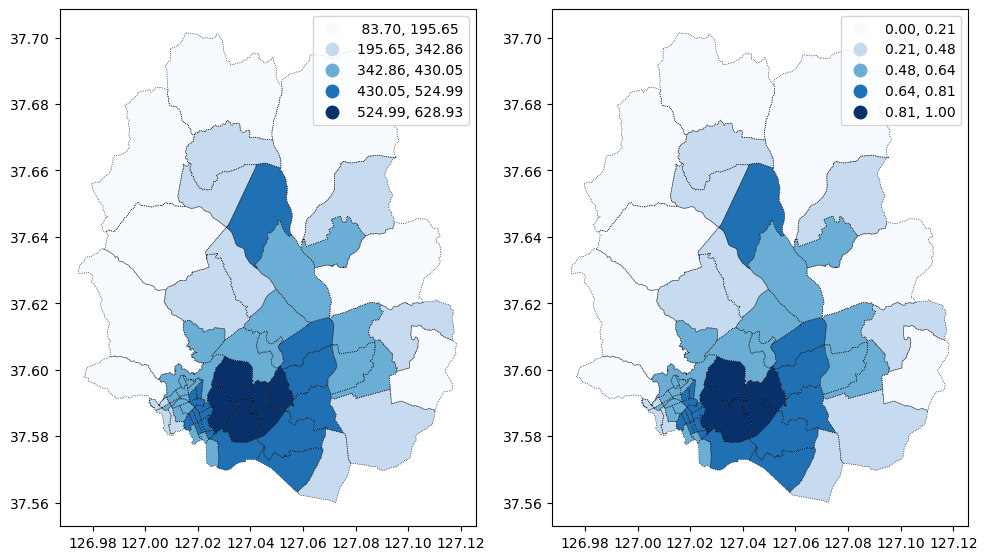

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# 첫 번째 지도: demand_
demand_.plot(
    column='sum',
    ax=ax[0],
    legend=True,
    cmap='Blues',
    scheme='FisherJenks'
)
demand_.boundary.plot(
    ax=ax[0],
    linestyle='dotted',
    lw=0.5,
    color='black',
    zorder=1
)

# 두 번째 지도: demand_nor
demand_nor.plot(
    column='sum_normalized',
    ax=ax[1],
    legend=True,
    cmap='Blues',
    scheme='FisherJenks'
)
demand_.boundary.plot(
    ax=ax[1],
    linestyle='dotted',
    lw=0.5,
    color='black',
    zorder=1
)

plt.tight_layout()
plt.show()

